In [ ]:
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import ConvLSTM2D
import numpy as np
#import pylab as plt
import tensorflow as tf
import cv2 as cv
import os
import matplotlib.pyplot as plt
import random

In [ ]:
#Mount Google Drive folder
from google.colab import drive

base_path = '/content/drive/My Drive/Tese/'
if not (drive):
  drive.mount(base_path)

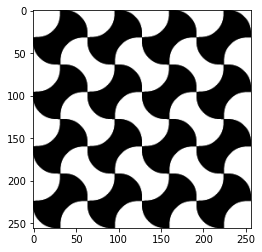

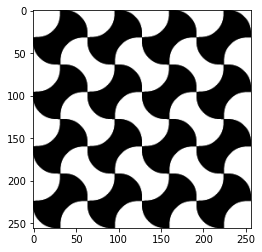

Image height: 256
Image width: 256
Color Channels: 3


In [ ]:
#Import image
tile = cv.imread(base_path + 'apple_grid_256x256.png')

#Normal cv.imshow() function crashes Colab
#from google.colab.patches import cv2_imshow
#cv2_imshow(tile)

#Display full tile
plt.imshow(cv.cvtColor(tile, cv.COLOR_BGR2RGB))
plt.show()

#Normalize tile
tile = np.array(tile, dtype=np.float32)
tile = tile / 255

#Display normalized tile (should look the same)
plt.imshow(cv.cvtColor(tile, cv.COLOR_BGR2RGB))
plt.show()

#tile.shape #height, width, channels
print('Image height:', tile.shape[0])
print('Image width:', tile.shape[1])
print('Color Channels:', tile.shape[2])

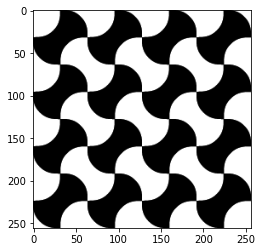

(256, 256, 1)


In [ ]:
#User defined variables

SEQUENCE = 10 #data points p/ target. NOT THE SAME AS BATCH SIZE

grayscale_mode = True

if grayscale_mode and tile.shape[2]==3:
  tile = cv.cvtColor(tile, cv.COLOR_BGR2GRAY)
  # Add a channel dimension since the images are grayscale.
  tile = np.expand_dims(tile, axis=-1)
  plt.imshow(tile[::,::, 0], cmap='gray', vmin=0, vmax=1)
else:
  plt.imshow(cv.cvtColor(tile, cv.COLOR_BGR2RGB))
plt.show()
print(tile.shape)
roll_array = tile

if grayscale_mode:
  COLOR_CHANNELS = 1
else:
  COLOR_CHANNELS = 3

#capture
CAPTURE_WIDTH = 75
CAPTURE_HEIGHT = 125

#Roller
ROLLER_SPEED = 7 #pixels per timestep
if ROLLER_SPEED*SEQUENCE < CAPTURE_HEIGHT:
  print("Warning: Area covered by input sequence smaller than pattern. Network may be unable to learn")

ROLLER_WIDTH = 300
ROLLER_HEIGHT = 2000



#Training
NB_EPOCH = 2000
BATCH_SIZE = 4 #tentar com batch size menor
VALIDATION_SPLIT = 0.3
VERBOSE = 1
N_SAMPLES = 1000
N_TRAIN_SAMPLES = int(N_SAMPLES * (1 - VALIDATION_SPLIT))
N_VAL_SAMPLES = int(N_SAMPLES * VALIDATION_SPLIT)
N_TRAINING_BATCHES = N_SAMPLES / BATCH_SIZE

In [ ]:
def roller_frame_generator(starting_point):
    """Yields sequential single frames"""

    roller_width = ROLLER_WIDTH
    roller_height = ROLLER_HEIGHT
    capture_height = CAPTURE_HEIGHT

    #print("Tile shape:", tile.shape)
    roll_array = tile

    horizontal_slice = tile

    while horizontal_slice.shape[1] < roller_width:
        horizontal_slice = np.concatenate((horizontal_slice, tile), axis=1)  # ---tile horizontally if necessary
        #print("tilling horizontally. New roller shape:", horizontal_slice.shape)

    roll_array = horizontal_slice
    #print(roll_array.shape)

    #Set initial point for roller
    roll_array = roll_array[starting_point:]

    while True:

        while roll_array.shape[0] < roller_height + capture_height:
            roll_array = np.concatenate((roll_array, horizontal_slice), axis=0)  # ---tile vertically if necessary
            #print("tilling verticaly. New roller shape:", roll_array.shape)

        #frame = np.zeros([CAPTURE_HEIGHT, CAPTURE_WIDTH, 3], dtype=np.uint8)
        #frame = roll_array[0:CAPTURE_HEIGHT, 0:CAPTURE_WIDTH, ::]
        yield roll_array[0:CAPTURE_HEIGHT, 0:CAPTURE_WIDTH].copy()
        roll_array = roll_array[ROLLER_SPEED:]


Sequence generator calls the frame generator with a random starting point and yields a sequence of 10 frames, as well as the next frame, which is to be predicted.
((10, capture_height, capture_width, channels), (capture_height, capture_width, channels))

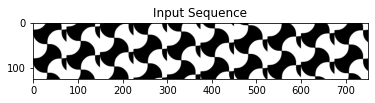

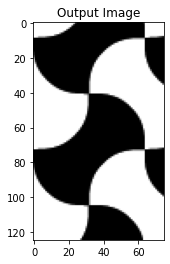

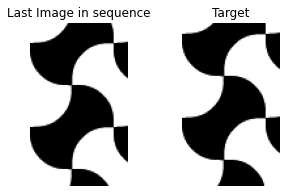

In [ ]:
def sequence_generator():
    sequence_size = 10
    """Yields sequences of frames
    """
    #Call frame generator with random starting point
    frame_gen = roller_frame_generator(random.randrange(0, tile.shape[0]))

    #Create object to store the sequence of frames
    #frame_sequence = np.zeros([sequence_size, CAPTURE_HEIGHT, CAPTURE_WIDTH, COLOR_CHANNELS], dtype=np.float32)
    frame_sequence = next(frame_gen)
    frame_sequence = np.expand_dims(frame_sequence, axis=0)

    #Loop the generator for frames
    for i in range(1, sequence_size):
        #frame_sequence[i] = next(frame_gen)
        frame_sequence = np.concatenate((frame_sequence, np.expand_dims(next(frame_gen), axis=0)), axis=0)
        #plt.imshow(cv.cvtColor(frame_sequence[i], cv.COLOR_BGR2RGB))
        #plt.show()
    target_frame = next(frame_gen)
    yield frame_sequence, target_frame.astype(np.float32)

#Concatenate images for side-by-side viewing
sequence_gen = sequence_generator()
sequence = next(sequence_gen)
sidebyside = sequence[0][0] #set = to first image
for j in range(1, len(sequence[0])):
    sidebyside = np.concatenate((sidebyside, sequence[0][j]), axis=1)
plt.imshow(cv.cvtColor(sidebyside, cv.COLOR_BGR2RGB))
plt.title("Input Sequence")
plt.show()

#Plot Target Frame
plt.imshow(cv.cvtColor(sequence[1], cv.COLOR_BGR2RGB))
plt.title("Output Image")
plt.show()

fig = plt.figure(figsize=(5, 3))

# Adds a subplot at the 1st position
fig.add_subplot(1, 2, 1)

# showing image
plt.imshow(cv.cvtColor(sequence[0][-1], cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Last Image in sequence")

# Adds a subplot at the 2nd position
fig.add_subplot(1, 2, 2)

# showing image
plt.imshow(cv.cvtColor(sequence[1], cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Target")
plt.show()


In [ ]:
#Convert to tf.Dataset object
dataset = tf.data.Dataset.from_generator(
    sequence_generator,
    output_signature=(
        tf.TensorSpec(shape=(SEQUENCE, CAPTURE_HEIGHT, CAPTURE_WIDTH, COLOR_CHANNELS), dtype=np.float32),
        tf.TensorSpec(shape=(CAPTURE_HEIGHT, CAPTURE_WIDTH, COLOR_CHANNELS), dtype=np.float32)))

input = dataset.batch(BATCH_SIZE)
validation_data = dataset.batch(BATCH_SIZE)

tf.data.experimental.enable_debug_mode()

In [ ]:
class CONVLSTM2D:
  @staticmethod
  def build(batch_size, time_steps, rows, cols, channels):
      inputNet = keras.Input(shape=(time_steps, rows, cols, channels)) #batch_shape=(10, 150, 100, 3)

      #convlstm2d = layers.Rescaling(1./255)(inputNet)
      #convlstm2d = layers.BatchNormalization()(inputNet)
      convlstm2d = layers.ConvLSTM2D(64, kernel_size=(3,3), padding="same", dropout=0.2, recurrent_dropout=0.1, return_sequences=True)(inputNet)
      convlstm2d = layers.BatchNormalization()(convlstm2d)
      convlstm2d = layers.ConvLSTM2D(64, kernel_size=(3,3), padding="same", dropout=0.2, recurrent_dropout=0.1, return_sequences=True)(convlstm2d)
      convlstm2d = layers.BatchNormalization()(convlstm2d)
      #convlstm2d = layers.ConvLSTM2D(16, kernel_size=(3,3), padding="same", dropout=0.2, recurrent_dropout=0.1, return_sequences=True)(convlstm2d)
      #convlstm2d = layers.BatchNormalization()(convlstm2d)
      convlstm2d = layers.ConvLSTM2D(channels, kernel_size=(3,3), padding="same", dropout=0.2, recurrent_dropout=0.1, return_sequences=False)(convlstm2d)


      model = keras.Model(inputNet, convlstm2d)
      return model

In [ ]:
OPTIMIZER = tf.keras.optimizers.SGD()#SGD()

model = CONVLSTM2D.build(batch_size = BATCH_SIZE, time_steps=SEQUENCE, rows=CAPTURE_HEIGHT, cols=CAPTURE_WIDTH, channels=COLOR_CHANNELS)

model.compile(loss="mse", optimizer=OPTIMIZER, metrics=["mse"])

model.summary()


#tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
#esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=12, verbose=0, mode='max')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)
best_checkpoint = keras.callbacks.ModelCheckpoint(base_path + 'models/ConvLSTM2D/ConvLSTM2D.h5', monitor='val_loss', save_best_only=True, verbose=1)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 125, 75, 1)]  0         
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 10, 125, 75, 16)   9856      
                                                                 
 batch_normalization_2 (Batc  (None, 10, 125, 75, 16)  64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 10, 125, 75, 16)   18496     
                                                                 
 batch_normalization_3 (Batc  (None, 10, 125, 75, 16)  64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 125, 75, 1)        616 

In [ ]:
#model = tf.keras.models.load_model('/content/drive/My Drive/Tese/ConvLSTM2D.h5')
tf.config.run_functions_eagerly(True)
history = model.fit(x = input,
		epochs=NB_EPOCH,
		verbose=1, # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
		validation_data=validation_data,
		callbacks=[reduce_lr,best_checkpoint])

Streaming output truncated to the last 5000 lines.
Epoch 751/2000
1/1 [==============================] - ETA: 0s - loss: 0.0376 - mse: 0.0376
Epoch 751: val_loss did not improve from 0.03303
1/1 [==============================] - 1s 1s/step - loss: 0.0376 - mse: 0.0376 - val_loss: 0.0435 - val_mse: 0.0435 - lr: 1.0000e-04
Epoch 752/2000
1/1 [==============================] - ETA: 0s - loss: 0.0431 - mse: 0.0431
Epoch 752: val_loss did not improve from 0.03303
1/1 [==============================] - 1s 1s/step - loss: 0.0431 - mse: 0.0431 - val_loss: 0.0402 - val_mse: 0.0402 - lr: 1.0000e-04
Epoch 753/2000
1/1 [==============================] - ETA: 0s - loss: 0.0373 - mse: 0.0373
Epoch 753: val_loss did not improve from 0.03303
1/1 [==============================] - 1s 851ms/step - loss: 0.0373 - mse: 0.0373 - val_loss: 0.0369 - val_mse: 0.0369 - lr: 1.0000e-04
Epoch 754/2000
1/1 [==============================] - ETA: 0s - loss: 0.0433 - mse: 0.0433
Epoch 754: val_loss did not improve 

1/1 [==============================] - 9s 9s/step


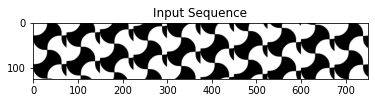

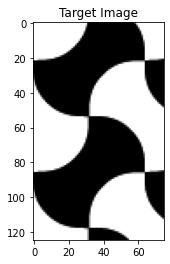

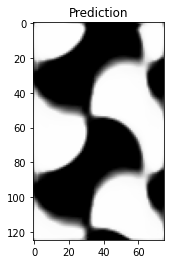

In [ ]:
#Test results

tf.data.experimental.enable_debug_mode()
batch1 = input.get_single_element()
loaded_model = tf.keras.models.load_model(base_path + 'models/ConvLSTM2D/ConvLSTM2D.h5')
prediction = loaded_model.predict(batch1[0], batch_size=BATCH_SIZE)
prediction.shape

#Concatenate images for side-by-side viewing
sidebyside = batch1[0][0][0] #set = to first image
for j in range(1, len(batch1[0][0])):
    sidebyside = np.concatenate((sidebyside, batch1[0][0][j]), axis=1)
plt.imshow(cv.cvtColor(sidebyside, cv.COLOR_BGR2RGB))
plt.title("Input Sequence")
plt.show()

#Plot Target Frame
target_image = batch1[1][0].numpy()
plt.imshow(cv.cvtColor(target_image, cv.COLOR_BGR2RGB))
plt.title("Target Image")
plt.show()

#Plot Output Frame
#prediction_image = prediction[0]
plt.imshow(cv.cvtColor(prediction[0], cv.COLOR_BGR2RGB))
plt.title("Prediction")
plt.show()
